# Process PicoCSV -> numpy (dont need to run)

In [ ]:
filename = '../data/131121_bucket_test/office_1/data.csv'

In [ ]:
!head {filename}

Time,Channel A,Channel B,Channel C,Channel D,Channel E
(s),(V),(V),(V),(V),(V)

-2.29999995,6.07679100,4.06116500,0.04242461,-1.91277000,-7.92363500
-2.29999895,6.07129800,4.05567100,0.04791845,-1.91795900,-7.91295300
-2.29999795,6.06610900,4.05567100,0.04242461,-1.91795900,-7.91844700
-2.29999695,6.07129800,4.05567100,0.05310707,-1.91795900,-7.91844700
-2.29999595,6.06610900,4.06116500,0.03174216,-1.91795900,-7.91295300
-2.29999495,6.07129800,4.06116500,0.04242461,-1.90727600,-7.91844700
-2.29999395,6.06610900,4.03980000,0.03693078,-1.92864100,-7.92363500


In [ ]:
import numpy as np

In [ ]:
data = np.loadtxt(filename, delimiter=',', skiprows=2)
data[:, 1] -= 6
data[:, 2] -= 4
data[:, 3] -= 0
data[:, 4] += 2
data[:, 5] += 8
data[data == -np.inf] = 0
data[data == np.inf] = 0
data[data == np.nan] = 0

In [ ]:
data[:, 1:] -= data[(data[:, 0] >0) & (data[:, 0] < 1), :][:, 1:].mean(axis=0)

In [ ]:
np.savez?

In [ ]:
np.savez('../data/131121_bucket_test/office_1.npz', data=data)

In [ ]:
data.shape, data.dtype

((10000004, 6), dtype('float64'))

# Load File

In [ ]:
  url = 'https://drive.google.com/file/d/12gDwtay-NWyfgPa-Z8HMM5P2Ur-pTK34/view?usp=sharing'
  filename = '131121_office_bucket_test.npz'

In [ ]:
!ls "{filename}" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

131121_office_bucket_test.npz


In [ ]:
import numpy as np

In [ ]:
bucket_data = np.load(filename)['data']
bucket_data[:, 1:] = (bucket_data[:, 1:] * (2**15 - 1) / 7).astype('int16')
data = bucket_data


## Transformers

In [ ]:
import numpy as np
import struct


from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=40e3, high=45e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return out

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename):  # filename: Union[str, path_like, File object]
        self.filename = filename
        self.file = None
        self.band_pass = BP(fs)
        self.envelope = MA(fs)
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            bp = self.band_pass(arr)
            out = self.envelope(np.abs(bp - bp.mean(axis=0)))
            # out = np.abs(hilbert(bp - bp.mean(axis=0), axis=0))
            return t, out.astype(arr.dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

# Visual old -- Dont run

In [ ]:
dt = np.diff(data[:, 0]).mean()
fs = 1.0 / dt
dt, fs

(-8.519997444000767e-05, -11737.092723004695)

In [ ]:
ping = data[(data[:, 0] > 1.0225) & (data[:, 0] < 1.0425), :]

In [ ]:
t = ping[:, 0]
ds = ping[:, 1:]

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.7/dist-packages/numpy/core/_m

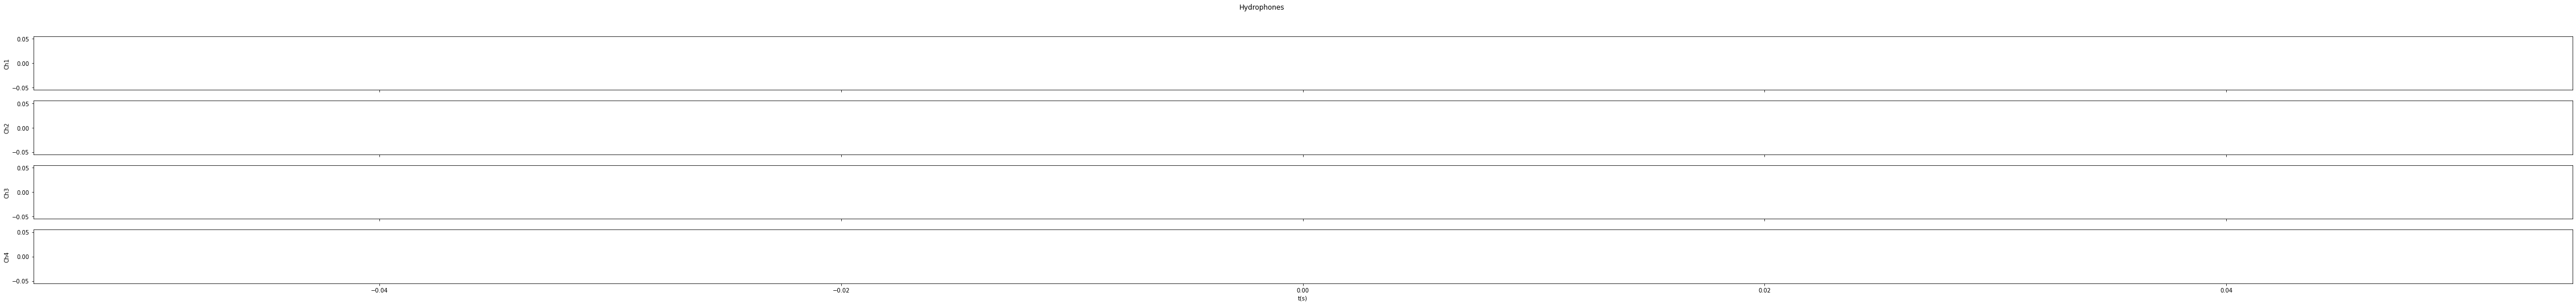

In [ ]:
f, axs = plt.subplots(ds.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(None, None)
for (i, ax), row, color in zip(enumerate(axs), ds.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
#   ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
import pywt

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(-0.5868546361502348, -586.8546361502348)

In [ ]:
coef, freqs=pywt.cwt(data,scale, 'mexh', sampling_period=dt) # , method='fft')  # Use fft for very large datasets

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 6000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

In [ ]:
ds_bp = BP(fs=fs, low=43e3, high=49e3)(ds)

In [ ]:
f, axs = plt.subplots(ds.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(None, None)
for (i, ax), row, color in zip(enumerate(axs), ds_bp.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
#   ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

# Visual

In [ ]:
dt = np.diff(data[:, 0]).mean()
fs = 1.0 / dt
dt, fs

(9.99999997000016e-07, 1000000.0029999841)

In [ ]:
# fs = 1e6 
# dt = 1.0 / fs
# dt, fs

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ping = data[(data[:, 0] > 1.021) & (data[:, 0] < 1.045), :]
t = ping[:, 0]
ds = ping[:, 1:]

In [ ]:
def plot_me(d, linewidth=0.5):    
    f, axs = plt.subplots(ds.shape[1], 1, figsize=(20,4), sharex='col')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

    loc = slice(None, None)
    for (i, ax), row, color in zip(enumerate(axs), d.T, colors):
      ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=linewidth)
      ax.set_ylabel(f"Ch{i+1}")

    ax.set_xlabel("t(s)")
    f.suptitle("Hydrophones")
    plt.show()

## Binary Search for optimal BP

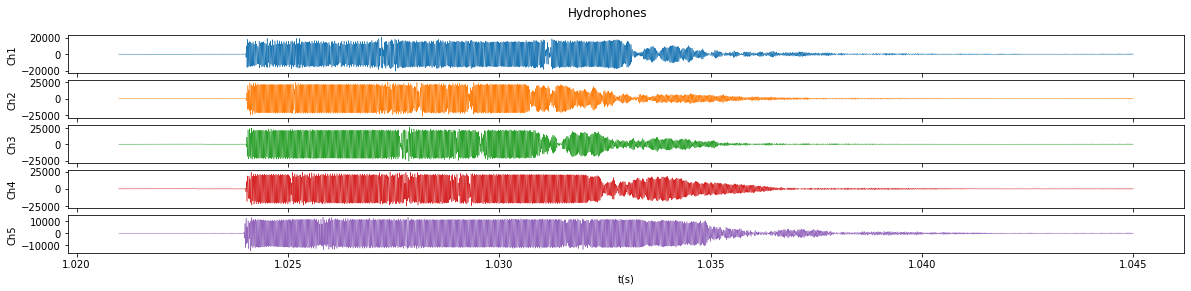

In [ ]:
plot_me(BP(fs=fs, low=20e3, high=50e3)(ds))

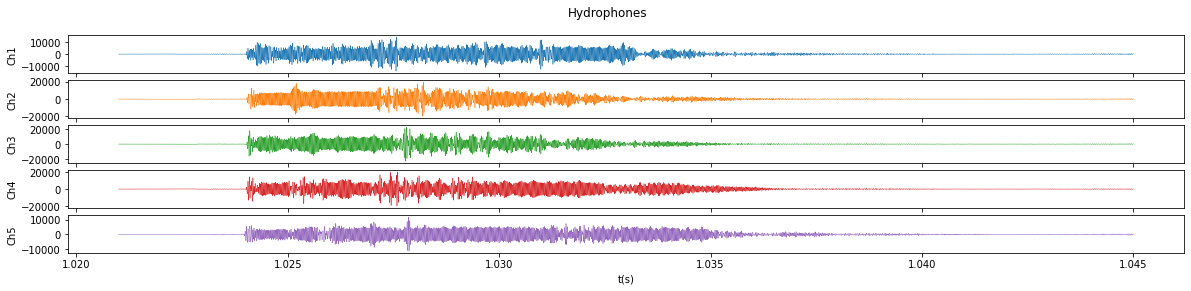

In [ ]:
plot_me(BP(fs=fs, low=20e3, high=35e3)(ds))

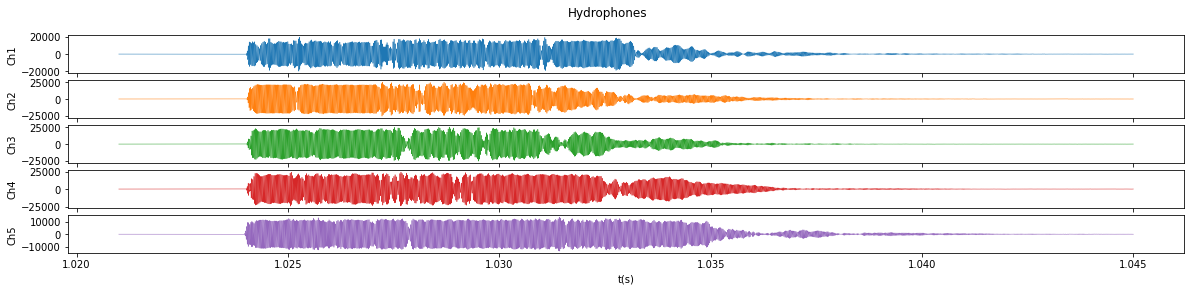

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=50e3)(ds))

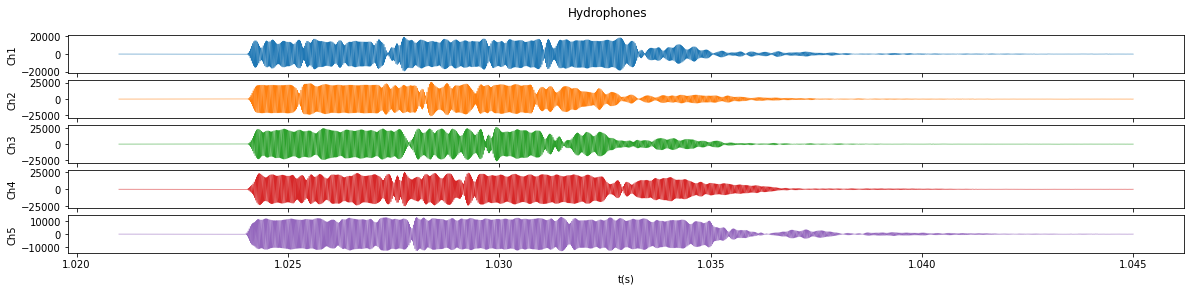

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=42.5e3)(ds))

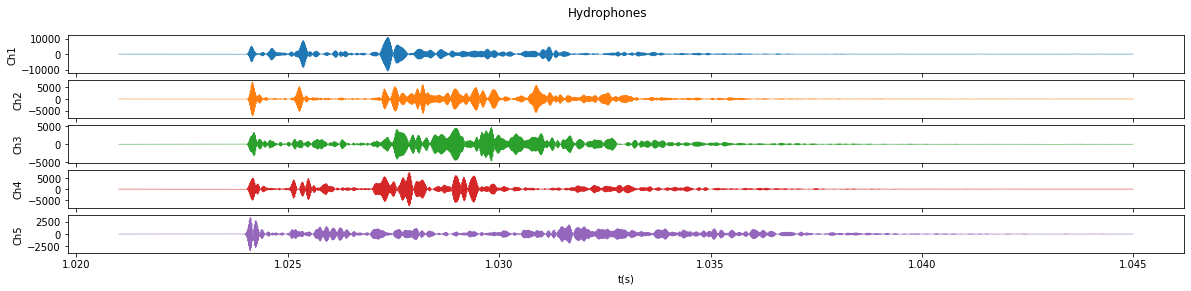

In [ ]:
plot_me(BP(fs=fs, low=42.5e3, high=50e3)(ds))

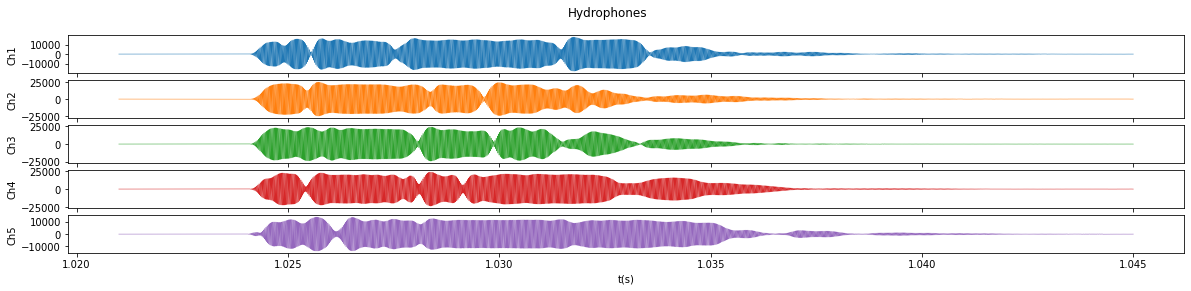

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=38.25e3)(ds))

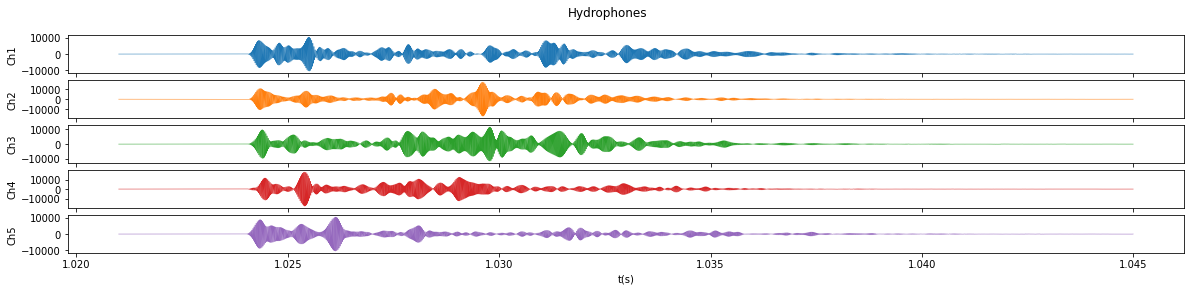

In [ ]:
plot_me(BP(fs=fs, low=38.25e3, high=42.5e3)(ds))

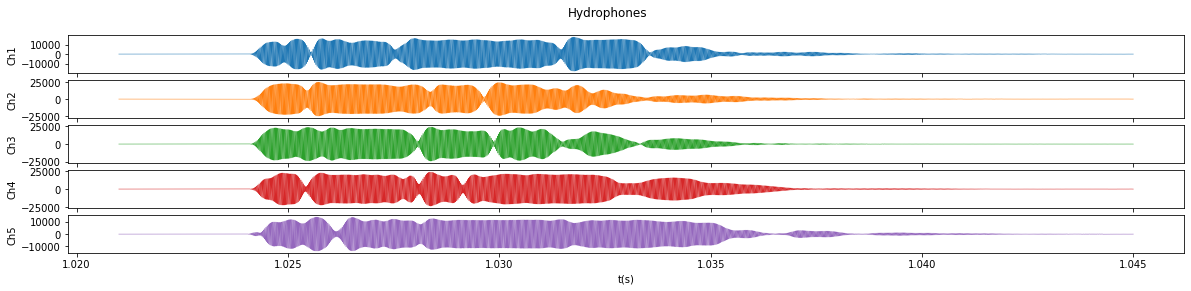

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=38.25e3)(ds))

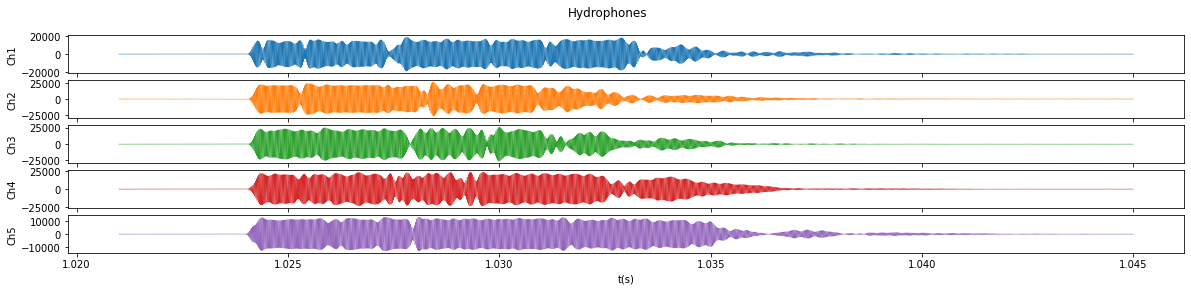

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=41e3)(ds))

## Envelope

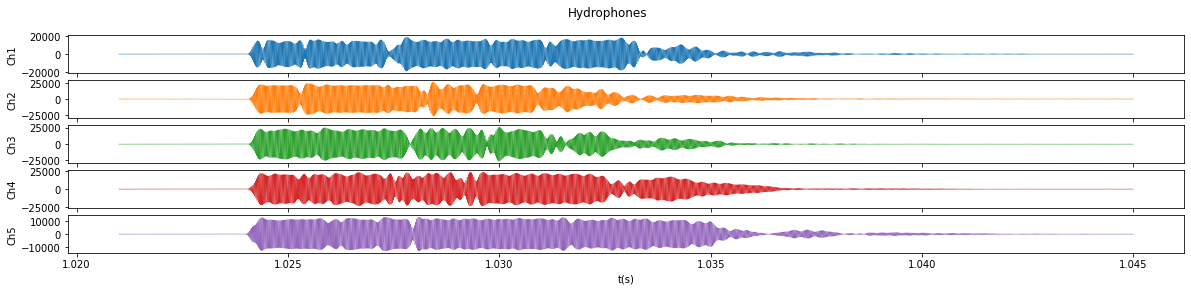

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=41e3)(ds))

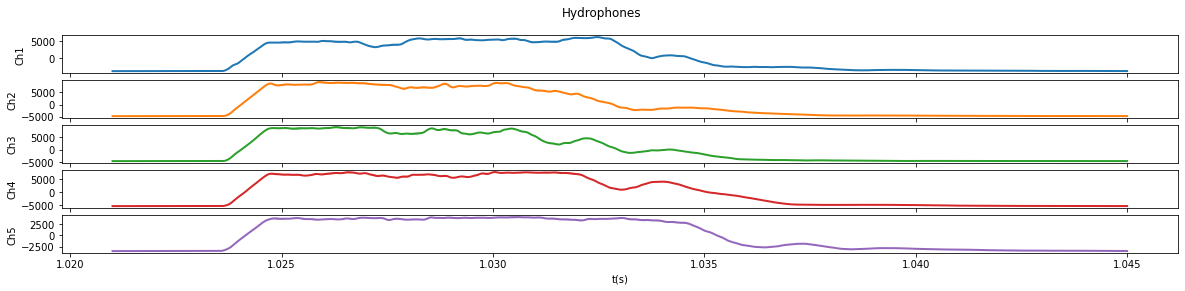

In [ ]:
plot_me(MA(fs=fs, dt=1e-3)(np.abs(BP(fs=fs, low=35e3, high=41e3)(ds))),linewidth=2)

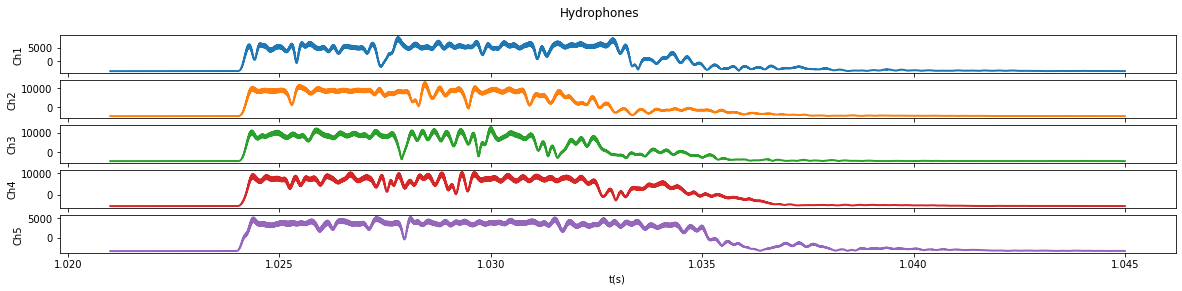

In [ ]:
plot_me(MA(fs=fs, dt=3e-5)(np.abs(BP(fs=fs, low=35e3, high=41e3)(ds))),linewidth=2)

In [ ]:
from scipy.signal import hilbert

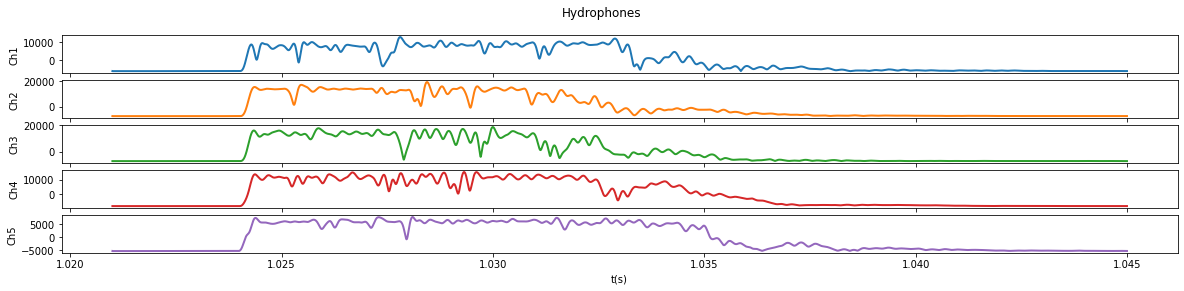

In [ ]:
plot_me(np.abs(hilbert(BP(fs=fs, low=35e3, high=41e3)(ds),axis=0)), linewidth=2)

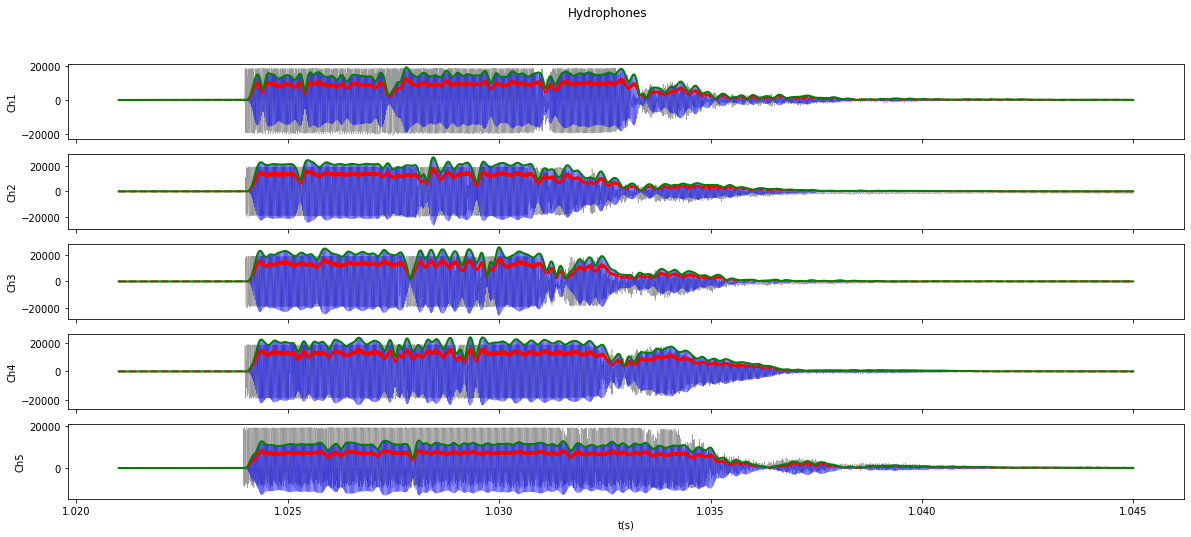

In [ ]:

lo, hi = 35e3, 41e3

f, axs = plt.subplots(ds.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(None, None)
for (i, ax), orig, bp, ma, hil, color in zip(enumerate(axs), 
                                             ds.T,
                                             BP(fs=fs, low=lo, high=hi)(ds).T,
                                         MA(fs=fs, dt=3e-5)(np.abs(BP(fs=fs, low=lo, high=hi)(ds))).T,
                                         np.abs(hilbert(BP(fs=fs, low=lo, high=hi)(ds),axis=0)).T,
                                         colors):
  ax.plot(t, orig, label=f"Ch{i+1}", color='gray', linewidth=0.5, alpha=0.8)
  ax.plot(t, bp, label=f"Ch{i+1}", color='blue', linewidth=0.5, alpha=0.6)
  ax.plot(t, ma,  '--',label=f"Ch{i+1}", color='red', linewidth=2)
  ax.plot(t, hil, label=f"Ch{i+1}", color='green', linewidth=2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

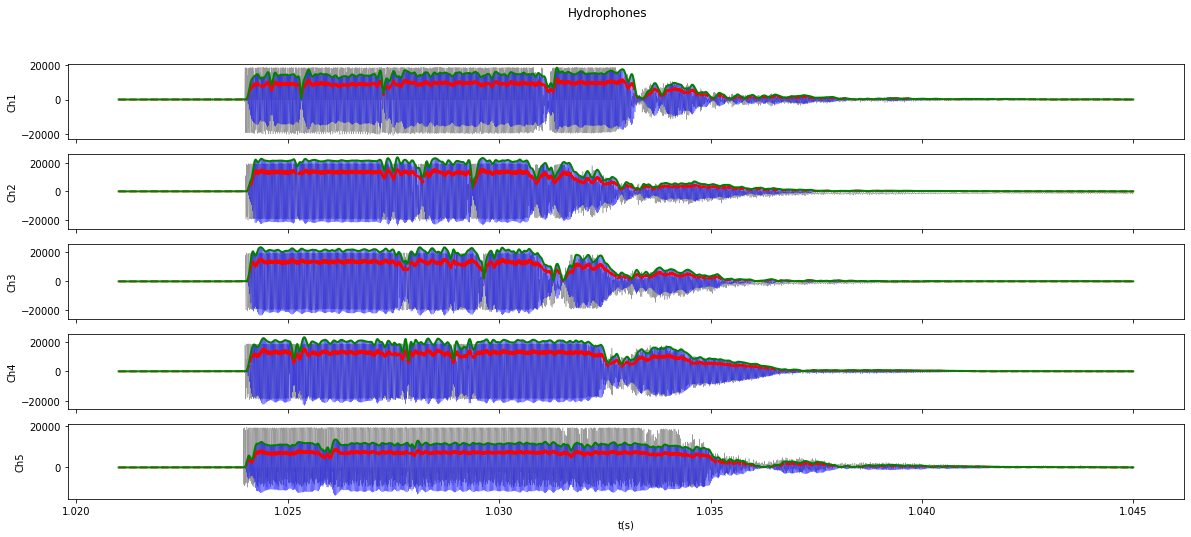

In [ ]:

lo, hi = 30e3, 40e3

f, axs = plt.subplots(ds.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(None, None)
for (i, ax), orig, bp, ma, hil, color in zip(enumerate(axs), 
                                             ds.T,
                                             BP(fs=fs, low=lo, high=hi)(ds).T,
                                         MA(fs=fs, dt=3e-5)(np.abs(BP(fs=fs, low=lo, high=hi)(ds))).T,
                                         np.abs(hilbert(BP(fs=fs, low=lo, high=hi)(ds),axis=0)).T,
                                         colors):
  ax.plot(t, orig, label=f"Ch{i+1}", color='gray', linewidth=0.5, alpha=0.8)
  ax.plot(t, bp, label=f"Ch{i+1}", color='blue', linewidth=0.5, alpha=0.6)
  ax.plot(t, ma,  '--',label=f"Ch{i+1}", color='red', linewidth=2)
  ax.plot(t, hil, label=f"Ch{i+1}", color='green', linewidth=2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

# Time MA vs Hilbert

In [ ]:
# %%time
# data_trans = np.abs(hilbert(BP(fs=fs, low=lo, high=hi)(data[:, 1:]),axis=0))
# CPU times: user 20.4 s, sys: 3.2 s, total: 23.6 s
# Wall time: 23.6 s

In [ ]:
%%time
data_trans = MA(fs=fs, dt=3e-5)(np.abs(BP(fs=fs, low=lo, high=hi)(data[:, 1:])))
# CPU times: user 2.57 s, sys: 172 ms, total: 2.74 s
# Wall time: 2.74 s

CPU times: user 2.96 s, sys: 31.1 ms, total: 2.99 s
Wall time: 3 s


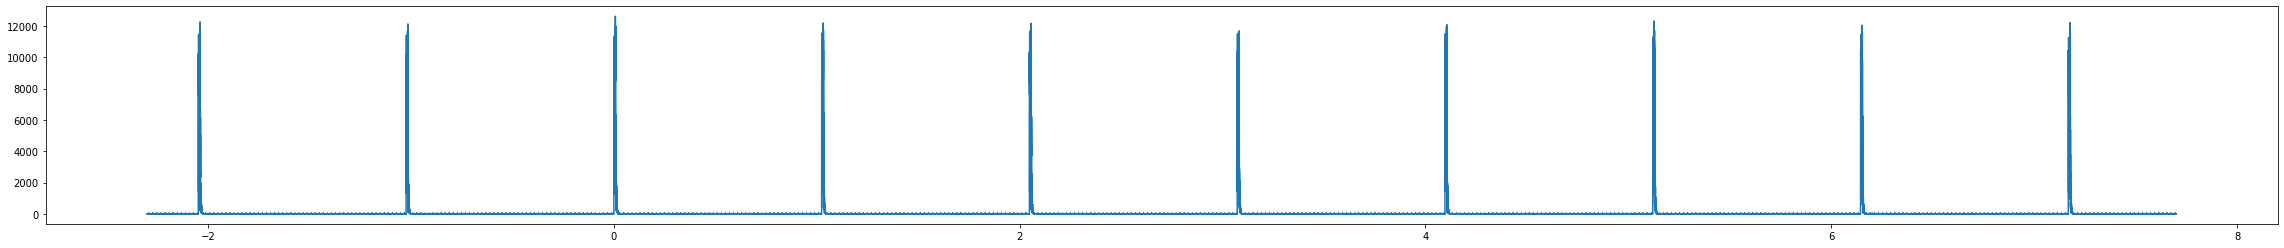

In [ ]:
plt.figure(figsize=(40,4))
plt.plot(data[:, 0], data_trans[:, 0])

# Use Old Data

In [ ]:
run_name = 'triangle_2'
filename = f"../data/041021_full_tests/{run_name}/pico.npts"

In [ ]:
!ls {filename}

In [ ]:
fs = 1e6
dt = 1.0 / fs

### Loader

In [ ]:
import numpy as np
import struct


from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=35e3, high=41e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return out

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        # out = np.empty_like(data)
        # for i in range(data.shape[1]):
        #     out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return np.abs(hilbert(data))

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, lo=35e3, hi=41e3):  # filename: Union[str, path_like, File object]
        self.filename = filename
        self.file = None
        self.band_pass = BP(fs=fs, low=lo, high=hi)
        self.envelope = MA(fs=fs, dt=3e-5)
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            bp = self.band_pass(arr)
            out = self.envelope(np.abs(bp - bp.mean(axis=0)))
            # out = np.abs(hilbert(bp - bp.mean(axis=0), axis=0))
            return t, out.astype(arr.dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

## Load Data

In [ ]:
reader = PicoDataLoader(filename)
reader.open()
t0 = reader.get()[0]
reader.close()
reader.open()

In [ ]:
from tqdm.notebook import tqdm
import subprocess
num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 976.7 + 1)

In [ ]:
arrs = []
t_curr = t0

with tqdm(total=num_chunks, desc=f'{run_name}: ') as progress_bar:
    try:
        for i in range(10000):
            t, arr = reader.get()
            arrs.append(arr)
            t_curr += dt * arr.shape[0]
            progress_bar.update(1)
        else:
            print('Data has more than 100000 sets')
    except StopIteration:
        pass

print('Stacking arrays...')
y = np.vstack(arrs)
t = np.arange(y.shape[0]) * dt
del arrs
reader.close()

y.shape, y.dtype, y.nbytes * 1e-9, "GB", t[-1], t_curr - t0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(80,10))
plt.plot(t[::500], y[::500])
# for xx in (ts - t0):
#     plt.axvline(x=xx, color='red', alpha=0.1, linewidth=5)

In [ ]:
i = 0
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
reader = PicoDataLoader(filename, lo=45e3, hi=50e3)
reader.open()
arrs = []

with tqdm(total=num_chunks, desc=f'{run_name}: ') as progress_bar:
    try:
        for i in range(100):
            t, arr = reader.get()
            arrs.append(arr)
            progress_bar.update(1)
        else:
            print('Data has more than 100000 sets')
    except StopIteration:
        pass

print('Stacking arrays...')
y = np.vstack(arrs)
t = np.arange(y.shape[0]) * dt
del arrs
reader.close()

In [ ]:
i = 2

loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc,1])

In [ ]:
y.shape

In [ ]:
import pywt

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

In [ ]:
coef, freqs=pywt.cwt(y, scale, 'mexh', sampling_period=dt) # , method='fft')  # Use fft for very large datasets

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 6000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

# Compare New and Old

### Load new

In [ ]:
dt = np.diff(data[:, 0]).mean()
fs = 1.0 / dt
dt, fs

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ping = data[(data[:, 0] > 1.021) & (data[:, 0] < 1.045), :]
t = ping[:, 0]
ds = ping[:, 1:]

In [ ]:
def plot_me(d, linewidth=0.5):    
    f, axs = plt.subplots(ds.shape[1], 1, figsize=(20,4), sharex='col')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

    for (i, ax), row, color in zip(enumerate(axs), d.T, colors):
        if t.shape[0] != row.shape[0]:
          ax.plot(np.arange(row.shape[0])*dt, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
        else:
            ax.plot(t, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
        ax.set_ylabel(f"Ch{i+1}")

    ax.set_xlabel("t(s)")
    f.suptitle("Hydrophones")
    plt.show()

In [ ]:
run_name = 'triangle_2'
filename = f"../data/041021_full_tests/{run_name}/pico.npts"

In [ ]:
fs = 1e6
dt = 1.0 / fs

In [ ]:
import numpy as np
import struct

class PicoStraightDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, lo=35e3, hi=41e3):  # filename: Union[str, path_like, File object]
        self.filename = filename
        self.file = None
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

In [ ]:
reader = PicoStraightDataLoader(filename)
reader.open()
t0 = reader.get()[0]
reader.close()
reader.open()
from tqdm.notebook import tqdm
import subprocess
num_chunks = int(100 // (dt * reader.bufsize))

arrs = []
t_curr = t0

with tqdm(total=num_chunks, desc=f'{run_name}: ') as progress_bar:
    try:
        for i in range(num_chunks):
            tt, arr = reader.get()
            arrs.append(arr)
            progress_bar.update(1)
        else:
            print('Data has more than 100000 sets')
    except StopIteration:
        pass

print('Stacking arrays...')
data_new = np.vstack(arrs)
data_new_t = np.arange(y.shape[0]) * dt
del arrs
reader.close()

# y.shape, y.dtype, y.nbytes * 1e-9, "GB", t[-1], t_curr - t0

In [ ]:
ping_new = data_new[(data_new_t > 1.021) & (data_new_t < 1.045), :]
ds_new = data_new[:, :]

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(data_new[:, 0])

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(data_new[:, 0])

In [ ]:
plot_me(BP(fs=fs, low=35e3, high=41e3)(ds))

In [ ]:
plot_me(BP(fs=fs, low=20e3, high=50e3)(data_new[int(fs * 0.25):int(fs*0.45), :]))

In [ ]:
p1 = data[(data[:, 0] > 1.012) & (data[:, 0] < 1.053), 1:]
p2 = data_new[int(fs * 0.289):int(fs*0.33), :]
low, high= 35e3, 41e3
plot_me(BP(fs=fs, low=low, high=high)(p1))
plot_me(BP(fs=fs, low=low, high=high)(p2))

In [ ]:
li
f, axs = plt.subplots(5 * 2, 1, figsize=(20,4), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

for (i, ax), row, color in zip(enumerate(axs[:5]), p1.T, colors):
    if t.shape[0] != row.shape[0]:
      ax.plot(np.arange(row.shape[0])*dt, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
    else:
        ax.plot(t, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
    ax.set_ylabel(f"Ch{i+1}")
    
for (i, ax), row, color in zip(enumerate(axs[5:]), p2.T, colors):
    if t.shape[0] != row.shape[0]:
      ax.plot(np.arange(row.shape[0])*dt, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
    else:
        ax.plot(t, row, label=f"Ch{i+1}", color=color, linewidth=linewidth)
    ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()